In [1]:
get_ipython().system('nvidia-smi')

Sun Mar 17 17:22:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:08:00.0 Off |                  N/A |
| 41%   30C    P8     1W / 260W |      5MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:42:00.0 Off |                  N/A |
| 41%   

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#!pip install tqdm

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers  
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import math
import keras as k
import pandas as pd
import numpy as np
from copy import copy
import scipy.io
from sklearn.decomposition import PCA
import random
from scipy.signal import find_peaks
from scipy import interpolate
from numpy import sin,cos,pi,array,linspace,cumsum,asarray,dot,ones
from pylab import plot, legend, axis, show, randint, randn, std,lstsq

from sklearn.manifold import MDS
import csv
import os
from pandas import read_csv
import ranges
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.special import iv

from sklearn.manifold import MDS
import csv
import os
from tqdm import tqdm 
from scipy import stats
import statistics  

In [6]:
# The path to save the models and read data from

### !!! please create and name the main folder that you would like to save all results -- ensure that the functions and data files are in this folder
folder = 'YA_Analysis'

path = '/home/twinner/'+ folder

# Insert the directory
import sys
sys.path.insert(0,path)


In [7]:
# Define these variables  specifically for your dataset!

# number of samples in each trial
trialsamp = 6000 #time series (samples) per trial


# Choose the maximum number of iterations to train the model
finalepoch = 10000

# load the input data


# -------------------2D kinematics ----------------------------
#datafilepath0 = path + '/DataStorage_6000_2D_kinematics_clean.csv' # path to input data
#inputdata = read_csv(datafilepath0, header = None)
#inputdata = inputdata.to_numpy()
#print('2D kinematics input data shape is: '+ str(inputdata.shape ))
#mod_name = '/Paper2_2Dkinematics_gaitsigs/'
#model_name  = '2Dkinematics_gaitsigs_reg_adam_LB499_110423'

# ------------------- 3D kinematics ----------------------------
#datafilepath1 = path + '/DataStorage_6000_3D_kinematics_clean.csv' # path to input data
#inputdata = read_csv(datafilepath1, header = None)
#inputdata = inputdata.to_numpy()
#print('3D kinematics input data shape is: '+ str(inputdata.shape ))

#mod_name = '/Paper2_3Dkinematics_gaitsigs/'
#model_name  = '3Dkinematics_gaitsigs_reg_adam_LB499_110523'


# ------------------- kinetics ----------------------------

#datafilepath2 = path + '/DataStorage_6000_kinetics_clean_031524.csv' # path to input data
#inputdata = read_csv(datafilepath2, header = None)
#inputdata = inputdata.to_numpy()
#print('kinetics input data shape is: '+ str(inputdata.shape ))

#mod_name = '/Paper2_kinetics_gaitsigs/'
#model_name  = 'kinetics_UPDATE_gaitsigs_reg_adam_LB499_031524'

#mod_name = '/Paper2_kinetics_gaitsigs/'
#model_name  = 'kinetics_NOAGRF_gaitsigs_reg_adam_LB499'


# ------------------- 3D kinematics + kinetics ----------------------------

datafilepath = path + '/DataStorage_6000_kinematics_and_kinetics_clean_031524.csv' # path to input data
inputdata = read_csv(datafilepath, header = None)
inputdata = inputdata.to_numpy()
print('3D kinematics + kinetics input data shape is: '+ str(inputdata.shape ))
mod_name = '/Paper2_alldata_gaitsigs/'
model_name  = 'alldata_gaitsigs_reg_adam_LB499_031624'


inshape = inputdata.shape[1]
feats = inputdata.shape[0]


3D kinematics + kinetics input data shape is: (60, 900000)


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler =  StandardScaler()  #MinMaxScaler()
scaler.fit(inputdata.T) # fit scaler on training data only 

# scale all the input data 
inputdata_s = scaler.transform(inputdata.T) #transform
print('scaled input data shape is: '+ str(inputdata_s.shape ))
print(scaler.mean_) # to get the mean for every column
print(scaler.var_) # to get the variance for every column
scipy.io.savemat(path + mod_name + model_name  + '_inputdata_s.mat', {'scaled_inputdata': inputdata_s})
#scipy.io.savemat(path + mod_name + model_name  + '_ScalarMean.mat', {'scaled_mean': scaler.mean_})
#scipy.io.savemat(path + mod_name + model_name  + '_ScalarVar.mat', {'scaled_var': scaler.var_})

scaled input data shape is: (900000, 60)
[ 1.37196280e+01  2.03700624e+00  2.80848543e+00  2.80743558e+01
 -1.14843629e+00 -9.87426959e+00 -2.80122431e+00 -7.60408439e+00
 -3.57140502e+00  1.18620261e+01  2.08268309e+00  3.98766988e+00
  2.59137948e+01 -5.15956995e-01 -8.78054453e+00 -2.49194430e+00
 -5.92248414e+00 -5.56557184e+00 -2.90744786e-02  1.74249685e-04
  5.23018437e-01  2.54287476e-02 -2.97598540e-01 -3.82393551e-02
  1.33368856e-01 -1.17689659e-01 -2.13341646e-02  2.60709191e-01
 -5.46393794e-02  2.53734600e-02  1.84961260e-01 -2.11480678e-02
  1.63662834e-02 -2.68949607e-01 -5.20380649e-04 -3.79008011e-03
  2.06052324e-01 -7.66964350e-03 -1.07300883e-02  2.99902781e-02
  7.42052032e-04  5.22689876e-01  5.08727790e-02 -4.20799949e-01
 -3.45347572e-02  1.28246152e-01 -1.61489554e-01 -3.18776904e-02
  2.62103313e-01 -3.29461704e-02 -3.13519761e-02 -1.40096181e-01
 -2.03405653e-02 -3.92090833e-04  2.70889636e-01  7.26005440e-03
 -1.32760445e-02 -1.87089945e-01  6.28420423e-03 

In [9]:
ExternalDriveHCs =  np.load(path + mod_name + model_name  + '_extdriveHCs.npy')
#scipy.io.savemat(path + mod_name + model_name + '_extdriveHCs.mat', {'ext_drive_sigs': ExternalDriveHCs})

## Cumulative Variance Accounted For By Cumulative PCs of Dynamics

In [11]:
from sklearn.metrics import explained_variance_score
numunits = 512
full_dyn_units = numunits*2
#variance_accounted_list = []
r_squared_list = []
Kinematics = inputdata_s

# Apply PCA
pca = PCA()
pca.fit(ExternalDriveHCs)

# Get PCA components and scores
coeff = pca.components_
score = pca.transform(ExternalDriveHCs)
latent = pca.explained_variance_
mu = np.mean(ExternalDriveHCs, axis=0)  # Calculate mean of HC

for j in range(feats): #feats 
    rank = slice(0, j)  # Python slice for first 6 components
    print(j)
    approximationRank_slice = np.dot(score[:, rank], coeff[rank, :]) + mu
    G_slice = approximationRank_slice
    model = k.models.load_model(path + mod_name + model_name + '_bestwhole.h5')
    model2 = k.models.Sequential(layers=[k.layers.Dense(feats, input_shape=(numunits,))])
    
    #restore network weights from the trained lidar model
    model2.set_weights(model.get_weights()[3:]) #need model in script
    angles = model2.predict(G_slice[:,:numunits],verbose = 1)
    r_squared = r2_score(Kinematics, angles, multioutput='variance_weighted')
    #variance_accounted = explained_variance_score(Kinematics, angles, multioutput='raw_values')
    
    # Store the variance accounted for in the list
    r_squared_list.append(r_squared)


r_squared_non_negative = np.maximum(r_squared_list, 0)  # incase the first PC throws a negative R2 (poor model fit)   
scipy.io.savemat(path + mod_name + model_name + 'Cumulative_VAF_all.mat', {'Cumulative_VAF': r_squared_non_negative})   
    

0
28125/28125 [==============================] - 22s 757us/step
1
28125/28125 [==============================] - 20s 722us/step
2
28125/28125 [==============================] - 21s 740us/step
3
28125/28125 [==============================] - 21s 737us/step
4
28125/28125 [==============================] - 21s 732us/step
5
28125/28125 [==============================] - 20s 693us/step
6
28125/28125 [==============================] - 21s 738us/step
7
28125/28125 [==============================] - 21s 749us/step
8
28125/28125 [==============================] - 21s 736us/step
9
28125/28125 [==============================] - 21s 739us/step
10
28125/28125 [==============================] - 20s 711us/step
11
28125/28125 [==============================] - 21s 754us/step
12
28125/28125 [==============================] - 22s 773us/step
13
28125/28125 [==============================] - 22s 774us/step
14
28125/28125 [==============================] - 21s 741us/step
15
28125/28125 [===================

# Reconstruct the angles from a reduced PC of Hs

188/188 [==============================] - 0s 968us/step


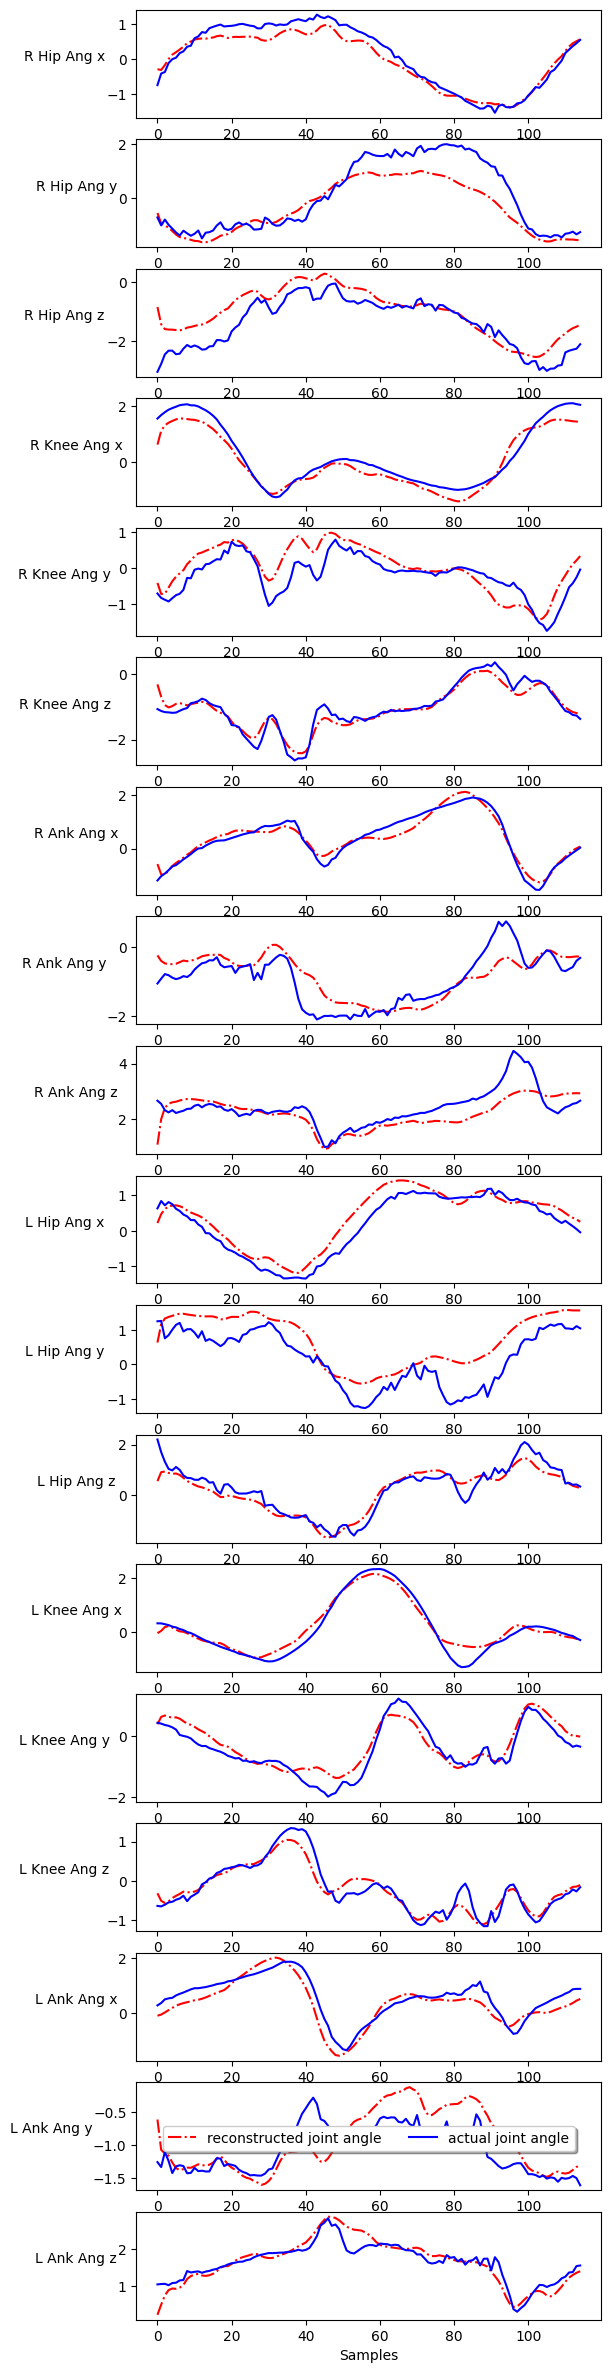

In [17]:
from sklearn.metrics import explained_variance_score

numunits = 512
Kinematics = inputdata_s

# Apply PCA
pca = PCA()
pca.fit(ExternalDriveHCs)

# Get PCA components and scores
coeff = pca.components_
score = pca.transform(ExternalDriveHCs)
latent = pca.explained_variance_
mu = np.mean(ExternalDriveHCs, axis=0)  # Calculate mean of HC


rank = [1] # Isolate only the first PC to reconstruct kinematics 
#rank = slice(0,10) # Isolate a subset of multiple PCs 
approximationRank_slice = np.dot(score[:, rank], coeff[rank, :]) + mu
G_slice = approximationRank_slice


model = k.models.load_model(path + mod_name + model_name + '_bestwhole.h5')
model2 = k.models.Sequential(layers=[k.layers.Dense(feats, input_shape=(numunits,))])
#restore network weights from the trained lidar model
model2.set_weights(model.get_weights()[3:]) #need model in script


angles = model2.predict(G_slice[0:6000,:numunits],verbose = 1) #1st subject only to save space

#%matplotlib inline
#%matplotlib notebook

#list if 3D labels for each feature in order
labels = ['R Hip Ang x', 'R Hip Ang y', 'R Hip Ang z', 'R Knee Ang x', 'R Knee Ang y', 'R Knee Ang z', 
'R Ank Ang x', 'R Ank Ang y', 'R Ank Ang z', 'L Hip Ang x', 'L Hip Ang y', 'L Hip Ang z', 'L Knee Ang x',
'L Knee Ang y', 'L Knee Ang z', 'L Ank Ang x', 'L Ank Ang y', 'L Ank Ang z'];

fig, axs = plt.subplots(18, 1, figsize=(6, 30))  # Adjust figsize as needed
#plt.figure(figsize=(18,10))
#t = np.linspace(0,len(ExternalDriveHCs))

#plt.title("All Trials", fontsize=14)
for i in range(18):
    axs[i].plot(angles[0:115,i],"r-.",markersize=8,label='reconstructed joint angle')
    axs[i].plot(Kinematics[0:115,i],"b-",markersize=8,label="actual joint angle")
    axs[i].set_ylabel(labels[i], rotation=0, labelpad= 30, ha='center')
    plt.xlabel("Samples")
   

# Adjust layout and display the plot
axs[i].legend(loc="lower center",bbox_to_anchor=(0.5, 1.5), ncol=3, fancybox=True, shadow=True)
#plt.tight_layout()
plt.show()

In [15]:
scipy.io.savemat(path + mod_name + model_name + 'YA003_ReconstructedKin_PCRankfull.mat', {'ReconstructAngle': angles[0:115,:]})

In [11]:
scipy.io.savemat(path + mod_name + model_name + 'YA003_ReconstructedKin_PCRank6.mat', {'ReconstructAngle': angles[0:115,:]})
scipy.io.savemat(path + mod_name + model_name + 'YA003_ScaledKin.mat', {'Kinematics': Kinematics[0:115,:]})

## Save a matfile

In [ ]:
#scipy.io.savemat(path + mod_name + model_name + 'ReconstructedKin_PCRank6.mat', {'ReconstructAngle': angles})
